## Data sets for object detection ##
Remove image areas that do not contain objects by cropping to make the images smaller and optimize the resolution of the input images. 

In [126]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData
from computervision.imageproc import enclosing_box,xywh2xyxy, xyxy2xywh, clipxywh

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [111]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'quadrant_enumeration/xrays')

# Output directory for the cropped images
output_dir = os.path.join(dataset_dir, 'cropped')
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Let's make sure that we have the expected number of images available
expected_images = 634
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print('Make sure to run the first notebook which downloads the data.')
print(f'Found {len(file_list)} images in {xrays_dir}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

data_dir: /app/data
Make sure to run the first notebook which downloads the data.
Found 634 images in /app/data/dentex/quadrant_enumeration/xrays.


## Load the annotations ##

In [112]:
json_file = os.path.join(dataset_dir, 'quadrant_enumeration/train_quadrant_enumeration.json')
parquet_file_name = f'{os.path.splitext(os.path.basename(json_file))[0]}.parquet'
parquet_file = os.path.join(data_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos,fdi,ada
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1,11,8
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2,12,7
2,0,1,"[1100.9259259259259, 451.85185185185185, 119.4...","[[1162, 451, 1212, 637, 1218, 663, 1220, 679, ...",3,24808,0,2,1316,2710,train_283.png,1,3,13,6
3,0,1,"[914.8148148148148, 466.66666666666663, 174.07...","[[965, 466, 1050, 562, 1088, 709, 1088, 760, 1...",4,28017,0,4,1316,2710,train_283.png,1,5,15,4
4,0,1,"[822.2222222222222, 484.25925925925924, 182.40...","[[915, 484, 981, 671, 997, 700, 1002, 721, 100...",5,35576,0,5,1316,2710,train_283.png,1,6,16,3


### Crop images using the quadrant annotations ###
We will crop the images so that they contain the bounding boxes for the selected quadrants

In [114]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None):
    offset_xy = (10, 80)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

# Function to plot segmentations
def plot_segmentations(image, segmentation_list, ax, label_list=None, color=None):
    if color is None:
        # If no color is provided, use a different color for each polygon
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(segmentation_list))))
    else:
        color_list = [color]*len(segmentation_list)
    ax.imshow(image)
    for s, seg in enumerate(segmentation_list):
        anchor = (min(seg[:, 0]), min(seg[:, 1]))
        contour = Polygon(xy=seg, 
                          linewidth=1.5, 
                          edgecolor=color_list[s],
                          facecolor=color_list[s], 
                          alpha=0.7)
        ax.add_patch(contour)
        if label_list is not None:
            ax.text(x=anchor[0], y=anchor[1], s=label_list[s], color=color_list[s])
    ax.set(xticks=[], yticks=[])
    return ax

# Create a function to build (x, y) tuples from segmentation lists
# The output of this function is an N x 2 array with coordinates
def segmentation_edges(segmentation: list) -> np.ndarray:
    output = None
    try:
        assert isinstance(segmentation, list)
        assert isinstance(segmentation[0], (int, np.int64))
        assert len(segmentation) % 2 == 0
    except AssertionError as e:
        logger.error('segmentation must be a flat even-lenth list of integer values')
    else:
        seg_x = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 0]
        seg_y = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 1]
        output = np.array(list(zip(seg_x, seg_y)))
    return output

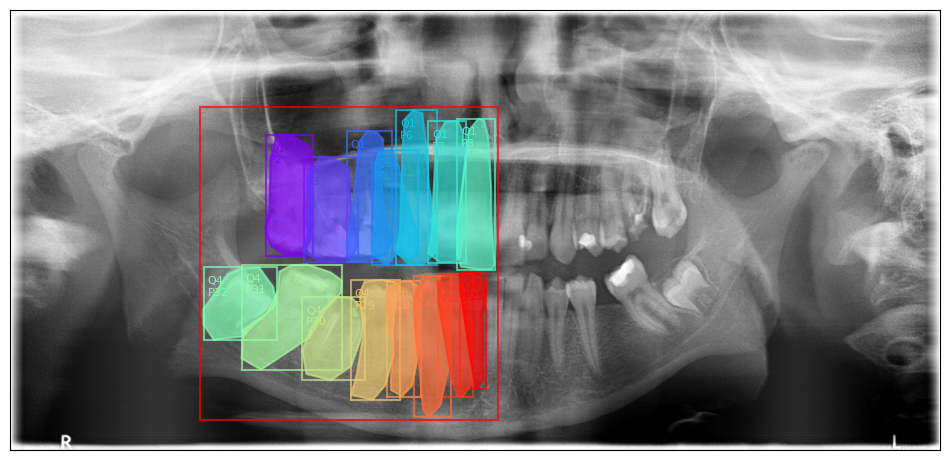

In [115]:
# Choose an image
seed = 114
rng = np.random.default_rng(seed=123)
file_name = rng.choice(a=df['file_name'].unique(), size=1)[0]
file = os.path.join(xrays_dir, file_name)
im = ImageData().load_image(file)

# Quadrants to include in the cropped image
quadrant_list = [1, 4]

# Annotations for the selected quadrants
dfq = df.loc[(df['file_name'] == file_name) & (df['quadrant'].isin(quadrant_list))]

# Get the bounding boxes and positions for these quadrants
box_list = [list(box) for box in dfq['bbox'].tolist()]
ada_list = dfq['ada'].tolist()
quad_list = dfq['quadrant'].tolist()
label_list = [f'Q{quad_list[b]}\nP{ada_list[b]}' for b in range(len(box_list))]

# Segmentations
segmentations = dfq['segmentation'].tolist()
# We need to convert this into a list of N x 2 arrays
points = [segmentation_edges(list(seg[0])) for seg in segmentations]

# Create a new bounding box that contains all of the selected bounding boxes
box = enclosing_box(bbox_list_xywh=box_list, offset=10)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))
ax = plot_boxes(image=im, ax=ax, box_list=box_list, label_list=label_list, color=None)
ax = plot_boxes(image=im, ax=ax, box_list=[box], label_list=None, color='r')
ax = plot_segmentations(image=im, segmentation_list=points, ax=ax)

### Crop the images ###

In [116]:
display(df.head())

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos,fdi,ada
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1,11,8
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2,12,7
2,0,1,"[1100.9259259259259, 451.85185185185185, 119.4...","[[1162, 451, 1212, 637, 1218, 663, 1220, 679, ...",3,24808,0,2,1316,2710,train_283.png,1,3,13,6
3,0,1,"[914.8148148148148, 466.66666666666663, 174.07...","[[965, 466, 1050, 562, 1088, 709, 1088, 760, 1...",4,28017,0,4,1316,2710,train_283.png,1,5,15,4
4,0,1,"[822.2222222222222, 484.25925925925924, 182.40...","[[915, 484, 981, 671, 997, 700, 1002, 721, 100...",5,35576,0,5,1316,2710,train_283.png,1,6,16,3


In [167]:
# Quadrants to include in the cropped image
quadrant_list = [1, 4]
quadrant_str = ''.join(str(q) for q in quadrant_list)

# List of files
file_list = sorted(list(df['file_name'].unique()))
print(len(file_list))

# Loop over the files
f = 123
file_name = file_list[f]

# Load the image
file = os.path.join(xrays_dir, file_name)
im = ImageData().load_image(file)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

# Annotations for the selected quadrants
dfq = df.loc[(df['file_name'] == file_name) & (df['quadrant'].isin(quadrant_list))]

# Create a new file name
cropped_file_name = f'{os.path.splitext(file_name)[0]}_quadrants_{quadrant_str}.png'
cropped_file = os.path.join(output_dir, cropped_file_name)

# Bounding boxes
box_list = [list(box) for box in dfq['bbox'].tolist()]
# The new bounding box that is large enough to contain all of the boxes in this list
box = enclosing_box(bbox_list_xywh=box_list, offset=10)
# This box cannot be larger in any dimension than the image
box = clipxywh(xywh=box, xlim=xlim, ylim=ylim, decimals=0)
# We need to get the xy coordinates for two diagonal corners
box_xyxy = xywh2xyxy(box)

# Segmentations
segmentations = dfq['segmentation'].tolist()
# We need to convert this into a list of N x 2 arrays
points = [segmentation_edges(list(seg[0])) for seg in segmentations]

# Crop the image and save it as a grey scale PIL image
im_cropped = im[box_xyxy[1]:box_xyxy[3], box_xyxy[0]:box_xyxy[2],]
# Convert the np.array into a PIL image
# We also get rid of the RGB dimensions because these are grey scale images.
im_pil = Image.fromarray(im_cropped).convert('L')
im_pil.save(cropped_file)

# Determine the limits of the cropped image
xlim_cropped, ylim_cropped = (0, im_cropped.shape[1]), (0, im_cropped.shape[0])

# We can now create the new bounding boxes for the cropped image. 
# We can keep width and height, just change the upper left anchor point
box_list_cropped = [[box[0] - box_xyxy[0], box[1] - box_xyxy[1], box[2], box[3]] for box in box_list]
# Because the image is smaller, we need to make sure that all the bounding boxes are clipped to the dimensions of the image
box_list_cropped = [clipxywh(bx, xlim=xlim_cropped, ylim=ylim_cropped, decimals=0) for bx in box_list_cropped]

634


In [165]:
bx = box_list_cropped[0]
print(bx)

[600.0, 86.0, 100.0, 330.0]


In [166]:
[clipxywh(bx, xlim=xlim_cropped, ylim=ylim_cropped, decimals=0)

[600, 86, 100, 330]

In [146]:
im_cropped.shape

(725, 710, 3)

In [147]:
box_list_cropped = [clipxywh(bx, xlim=xlim_cropped, ylim=ylim_cropped, decimals=0) for bx in box_list]
box_list_cropped

[[710, 504, 0, 221],
 [710, 472, 0, 253],
 [710, 428, 0, 297],
 [710, 488, 0, 237],
 [710, 476, 0, 249],
 [710, 494, 0, 231],
 [710, 478, 0, 247],
 [710, 725, 0, 0],
 [710, 725, 0, 0],
 [710, 725, 0, 0]]